In [1]:
%env CUDA_VISIBLE_DEVICES=7

env: CUDA_VISIBLE_DEVICES=7


In [15]:
import os
import torch
import sbibm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import pickle

sns.set_theme()

In [16]:
mpl.rcParams['text.usetex'] = True
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsfonts}'

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [32]:
import pickle

with open(os.path.join("minmax", "two_moons.pkl"), "rb") as f:
    mins, maxs = pickle.load(f)

In [30]:
def get_grid(mins, maxs, K = 200):
    # K -> discretization of the grid (assumed same for each dimension)
    d = len(mins) # dimensionality of theta
    ranges = [np.arange(mins[i], maxs[i], (maxs[i] - mins[i]) / K) for i in range(d)]
    return np.array(np.meshgrid(*ranges)).T.astype(np.float32)

In [34]:
theta_grid = get_grid(mins, maxs)

In [35]:
theta_grid.shape

(200, 200, 2)

In [21]:
def get_thetas_grid(mins, maxs):
    theta1 = np.linspace(mins[0], maxs[0], 200)
    theta2 = np.linspace(mins[1], maxs[1], 200)
    dA = (theta1[1] - theta1[0]) * (theta2[1] - theta2[0]) # area element (for approximating integral)
    thetas_unflat = np.meshgrid(theta1, theta2)
    return np.vstack((thetas_unflat[0].flatten(), thetas_unflat[1].flatten())).T.astype(np.float32), dA

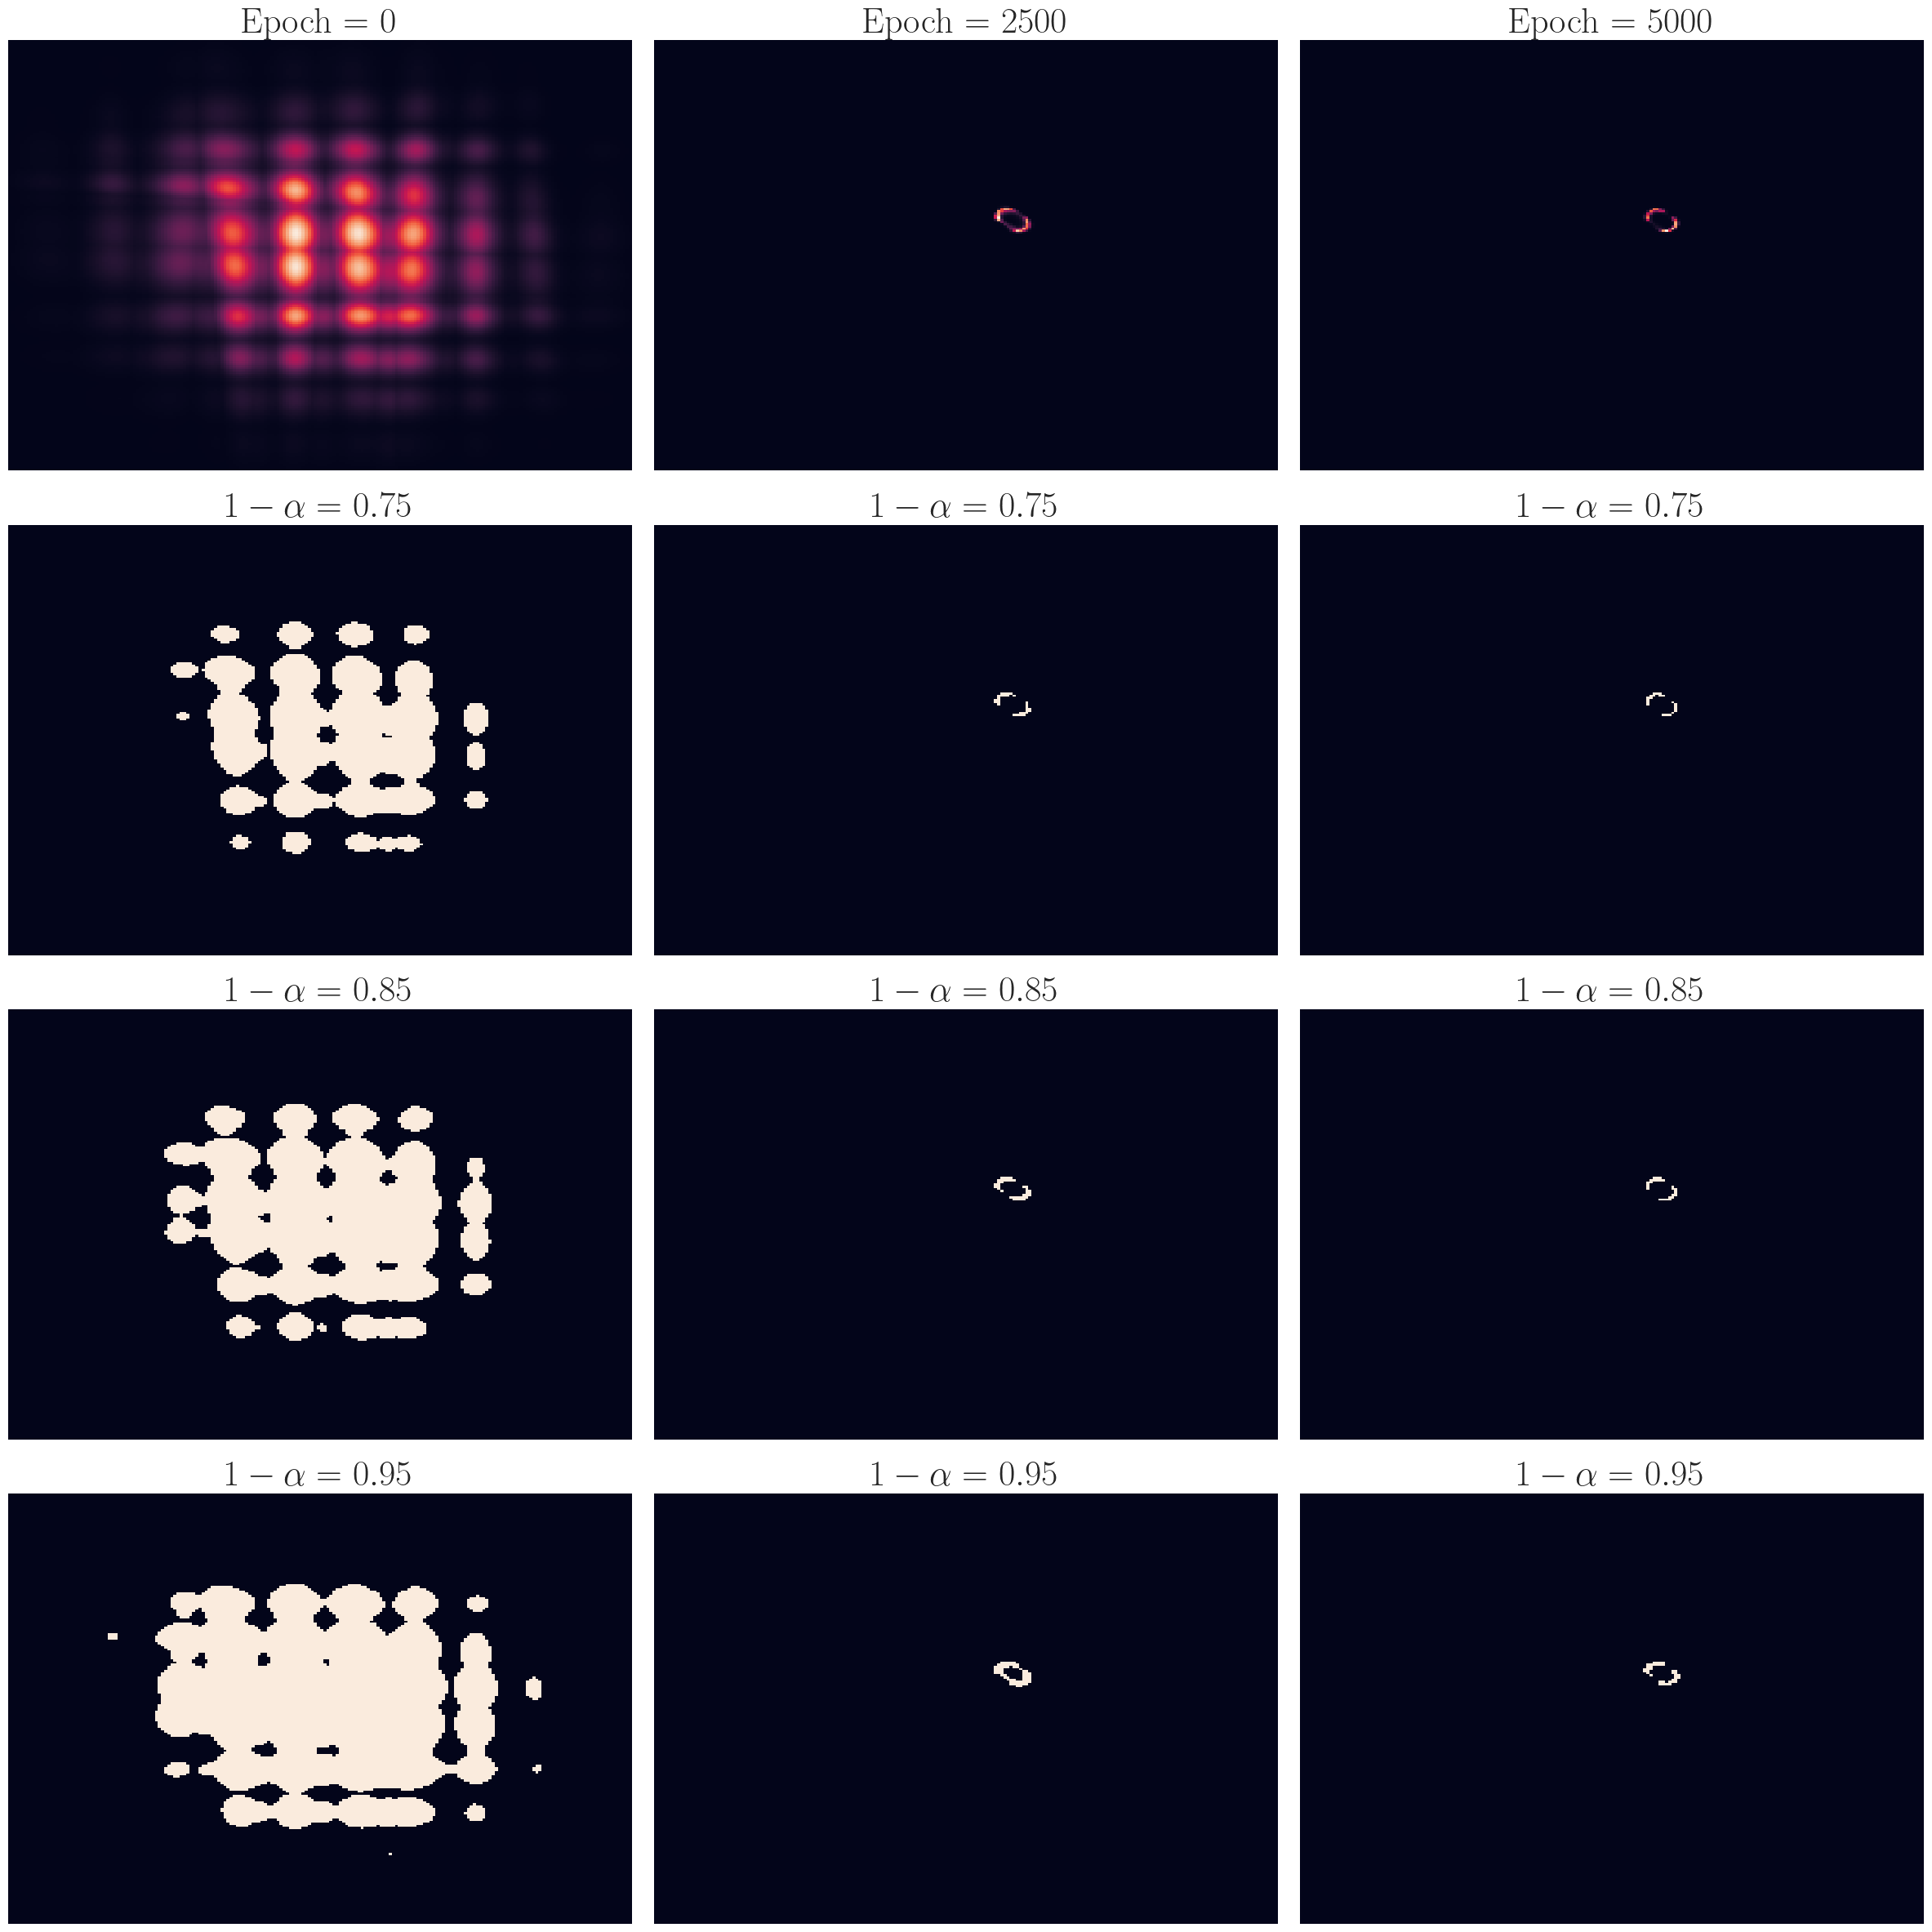

In [22]:
task_name = "two_moons"

task = sbibm.get_task(task_name)
prior = task.get_prior_dist()
simulator = task.get_simulator()

sims = 10_000 # same number for both test and calibration
calibration_theta = prior.sample((sims,))
calibration_x = simulator(calibration_theta)
calibration_theta = calibration_theta[...,:2]

thetas, dA = get_thetas_grid(-3, 3)
test_sim = 1
test_theta = prior.sample((test_sim,))
test_x = simulator(test_theta)
test_theta = test_theta[...,:2]
test_x_tiled = np.tile(test_x, (thetas.shape[0], 1)).astype(np.float32)

fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(24,24))

for j, epoch in enumerate([0, 2500, 5000]):
    device = "cpu"
    fn = f"{task_name}"
    cached_fn = os.path.join("trained", f"{task_name}_iter={epoch}.nf")
    with open(cached_fn, "rb") as f:
        encoder = pickle.load(f)
    encoder.to(device)

    cal_scores = 1 / encoder.log_prob(calibration_theta.to(device), calibration_x.to(device)).detach().cpu().exp().numpy()
    desired_coverages = [0.75, 0.85, 0.95]
    
    probs = encoder.log_prob(thetas, test_x_tiled).detach().cpu().exp().numpy()
    probs_map = probs.reshape((200, 200))
    
    axs[0, j].set_title("Epoch = " + str(epoch), fontsize=32)
    axs[0, j].tick_params(left=False, bottom=False)
    axs[0, j].set(xticklabels=[], yticklabels=[])
    sns.heatmap(probs_map, ax=axs[0, j], cbar=False, xticklabels=False, yticklabels=False)
    
    for i, desired_coverage in enumerate(desired_coverages):
        ax = axs[i + 1, j]
        ax.set_title(r"$1-\alpha = " + str(desired_coverage) + "$", fontsize=32)
        conformal_quantile = np.quantile(cal_scores, q = desired_coverage)
        sns.heatmap((1 / probs_map) < conformal_quantile, ax=ax, cbar=False, xticklabels=False, yticklabels=False)

plt.tight_layout()

In [24]:
cal_scores = 1 / encoder.log_prob(calibration_theta.to(device), calibration_x.to(device)).detach().cpu().exp().numpy()
conformal_quantile = np.quantile(cal_scores, q = desired_coverage)
probs = encoder.log_prob(thetas, test_x_tiled).detach().cpu().exp().numpy()
area = np.sum((1 / probs) < conformal_quantile) * dA

In [25]:
area

0.034544582207519804

In [19]:
desired_coverage

0.95

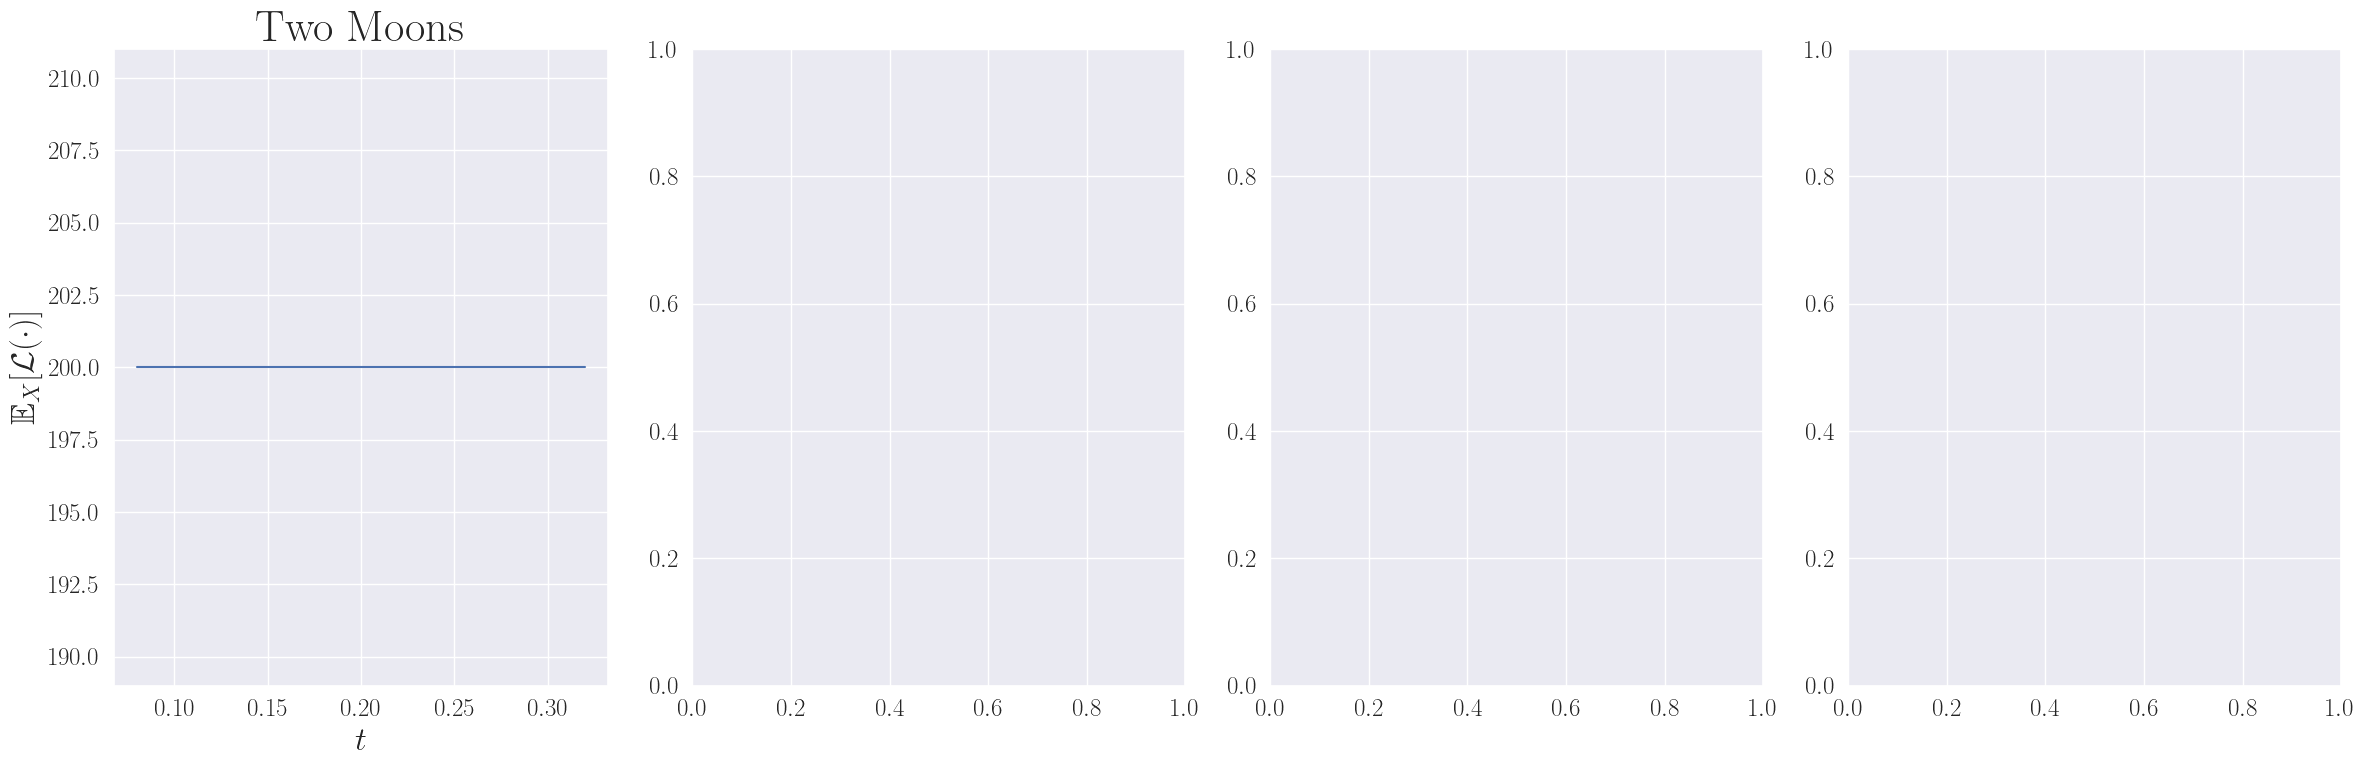

In [10]:
task_names = [
    'two_moons',
    # 'slcp',
    # 'gaussian_mixture',
    # 'gaussian_linear',
]

task_name_titles = [
    'Two Moons',
    # 'SLCP',
    # 'Gaussian Mixture',
    # 'Gaussian Linear',
]

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(24,8))
# axs[0].set_ylabel("$\mathbb{E}_X[\mathcal{L}(\cdot)]$",fontsize=24)
for i, task_name in enumerate(task_names):
    df = pd.read_csv(f'{task_name}_sizes.csv', header=None, index_col=0)
    axs[i].set_title(task_name_titles[i], fontsize=32)
    axs[i].set_xlabel(r"$t$",fontsize=24)

    # if i % 2 == 1:
    #     axs[i].set_xlabel(r"$t$",fontsize=24)
    # else:
    #     axs[i].set_xlabel(" ")

    if i == 0:
        axs[i].set_ylabel("$\mathbb{E}_X[\mathcal{L}(\cdot)]$",fontsize=24)
    else:
        axs[i].set_ylabel(" ")

    sns.lineplot(data=df, x=1, y=2, ax=axs[i])

plt.tight_layout()
# plt.savefig(f"sbi_set_sizes.png")